In [1]:
import torch
from torch import Tensor
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as tt
import torchvision

from tqdm import tqdm

from CNNmodel import ConvModel

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples
import config

In [2]:
print_config()

RANDOM_SEED  :   110404
DATA_DIR     :   ./data
USED_DATA    :  CIFAR10
LEAKY        :    False
NOSIE        :    False
NUM_LABELLED :    10000
DEVICE       :   cuda:0
EPOCHS       :      100
BATCH_SIZE   :      256
LEARNING_RATE:     0.01


In [3]:
torch.manual_seed(config.RANDOM_SEED)

In [26]:
PATH = f'{config.USED_DATA}/CNN{config.NUM_LABELLED}'

In [5]:
X_train, y_train, X_test, y_test, classes = load_data(0, 1)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
n_classes = len(classes)
channels = X_train.shape[1]

In [7]:
X_train, y_train = supervised_samples(X_train, y_train, config.NUM_LABELLED, n_classes)

In [8]:
y_train = y_train.type(torch.ByteTensor)
y_test = y_test.type(torch.ByteTensor)

In [9]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
train_tfm = tt.Compose([
	tt.ToPILImage(),
	tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
	tt.RandomHorizontalFlip(),
	tt.ToTensor(),
	tt.Normalize(mean, std, inplace=True)
])

valid_tfm = tt.Compose([
	tt.ToPILImage(),
	tt.ToTensor(),
	tt.Normalize(mean, std)
])

In [10]:
train_ds = CustomDataSet(X_train, y_train, train_tfm)
valid_ds= CustomDataSet(X_test, y_test, valid_tfm)

In [11]:
def show_image(img, label):
	print("Label: ("+str(label)+")")
	plt.imshow(img.permute(1,2,0))

In [12]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [13]:
train_dl = DataLoader(train_ds, config.BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, config.BATCH_SIZE, num_workers=3, pin_memory=True)

In [14]:
def show_batch(dl: DataLoader):
	for images, labels in dl:
		fig,ax= plt.subplots(figsize=(12,12))
		ax.set_xticks([]) #hide ticks
		ax.set_yticks([])
		ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
		break # printing only first 64 images from first batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


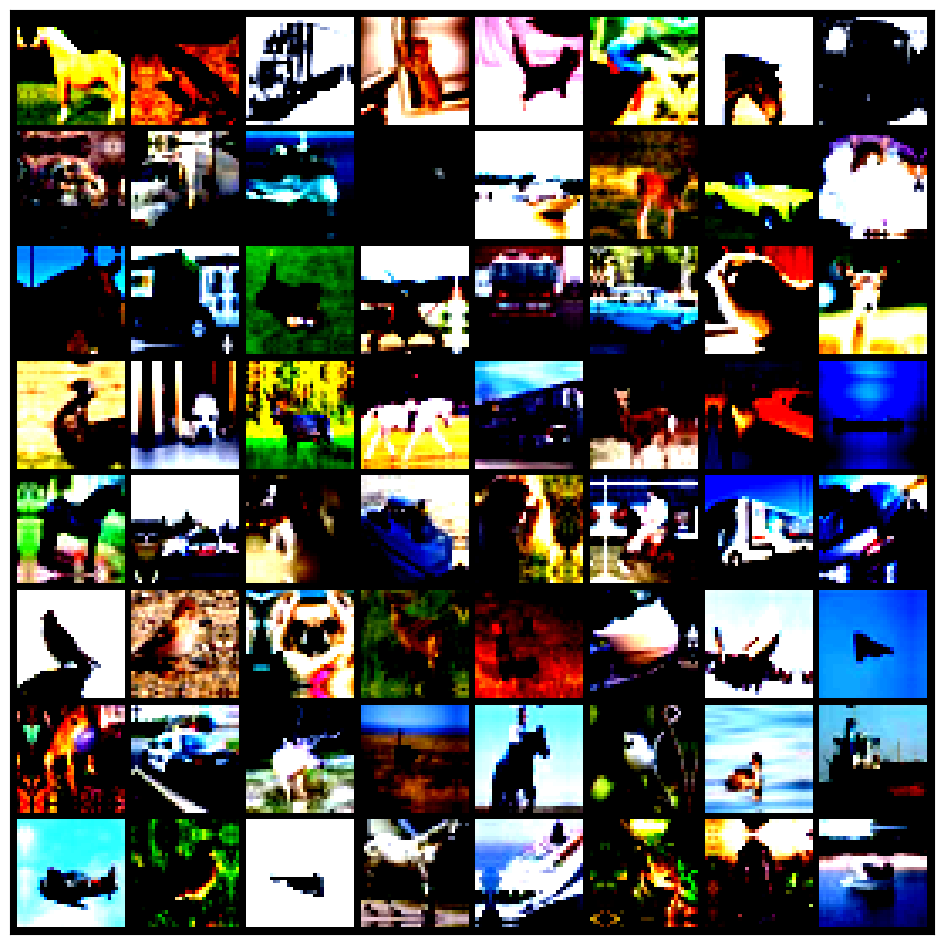

In [15]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


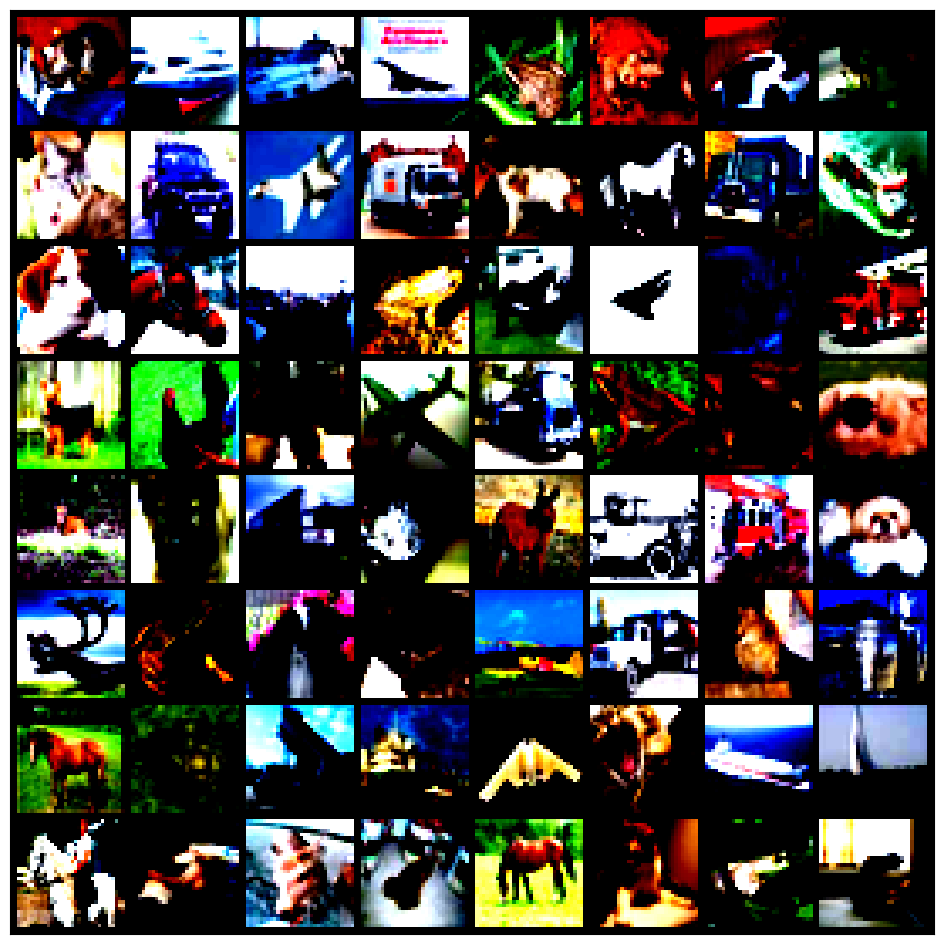

In [16]:
show_batch(valid_dl)

In [17]:
train_dl = DeviceDataLoader(train_dl, config.DEVICE)
valid_dl = DeviceDataLoader(valid_dl, config.DEVICE)

In [18]:
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class Model(nn.Module):
	def __init__(self, in_channels, num_classes):
		super().__init__()
		

		self.conv = ConvModel(in_channels)
		
		self.classifier = nn.Linear(512, num_classes)
		

		self.criterion = nn.CrossEntropyLoss()
		
	def forward(self, X: Tensor):
		out = self.conv(X)
		out = self.classifier(out)
		return out
	

	def training_step(self, batch) -> Tensor:
		images, labels = batch 
		out = self(images)                  # Generate predictions
		loss = self.criterion(out, labels) # Calculate loss
		return loss

	def eval_step(self, batch, eval = True):
		images, labels = batch 
		out = self(images)                    # Generate predictions
		loss = self.criterion(out, labels)   # Calculate loss
		acc = accuracy(out, labels)           # Calculate accuracy
		if eval:
			return {'val_loss': loss.detach(), 'val_acc': acc}
		else:
			return {'train_loss': loss.detach(), 'train_acc': acc}
	
	def evaluate_epoch_end(self, outputs, eval = True):
		if eval:
			loss_key = 'val_loss'
			acc_key = 'val_acc'
		else:
			loss_key = 'train_loss'
			acc_key = 'train_acc'

		batch_losses = [x[loss_key] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		batch_accs = [x[acc_key] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
		
		return {loss_key: epoch_loss.item(), acc_key: epoch_acc.item()}
	
	def epoch_end(self, epoch, result):
		print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, train_acc: {result['train_acc']:.4f}, val_acc: {result['val_acc']:.4f}")
	
	@torch.no_grad()
	def evaluate(self, loader, eval = True):
		self.eval()
		outputs = [self.eval_step(batch, eval) for batch in loader]
		return self.evaluate_epoch_end(outputs, eval)
	
	@staticmethod
	def get_lr(optimizer: optim.Optimizer):
		for param_group in optimizer.param_groups:
			return param_group['lr']

	def fit(self, epochs, max_lr, train_loader: DeviceDataLoader, val_loader: DeviceDataLoader, weight_decay=0, grad_clip=None, opt_func = optim.SGD, PATH = "./", save_best = True):
		if config.DEVICE == 'cuda:0':
			torch.cuda.empty_cache()
		
		history = []

		optimizer = opt_func(self.parameters(), max_lr, weight_decay=weight_decay)

		sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

		best_val = 0

		for epoch in range(epochs):
			self.train()
			train_losses = []
			lrs = []

			print(f"Epoch [{epoch}]")

			for batch in tqdm(train_loader):
				loss = self.training_step(batch)

				train_losses.append(loss)

				loss.backward()

				if grad_clip:
					nn.utils.clip_grad_value_(self.parameters(), grad_clip)
				
				optimizer.step()
				optimizer.zero_grad()

				lrs.append(self.get_lr(optimizer))
				sched.step()
			
			result = self.evaluate(val_loader)

			result['train_loss'] = torch.stack(train_losses).mean().item()
			result['lrs'] = lrs

			print(f"train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

			if result['val_acc'] >= best_val:
				torch.save(self.state_dict(), PATH)
			
			history.append(result)
		
		return history
				

In [20]:
model = Model(channels, n_classes).to(config.DEVICE, non_blocking=True)

In [21]:
%%time
history = model.fit(config.EPOCHS, config.LEARNING_RATE, train_dl, valid_dl, weight_decay=1e-4, grad_clip=0.1, opt_func=optim.Adam, PATH=PATH+".pt")

Epoch [0]


100%|██████████| 40/40 [00:05<00:00,  6.77it/s]


train_loss: 1.8296, val_loss: 1.6100, val_acc: 0.4310
Epoch [1]


100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


train_loss: 1.2909, val_loss: 1.1925, val_acc: 0.5770
Epoch [2]


100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


train_loss: 1.1158, val_loss: 1.1061, val_acc: 0.6063
Epoch [3]


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


train_loss: 1.0328, val_loss: 1.4581, val_acc: 0.5437
Epoch [4]


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


train_loss: 0.9237, val_loss: 1.0644, val_acc: 0.6427
Epoch [5]


100%|██████████| 40/40 [00:05<00:00,  7.83it/s]


train_loss: 0.9305, val_loss: 1.1287, val_acc: 0.6272
Epoch [6]


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


train_loss: 0.8433, val_loss: 0.9237, val_acc: 0.6812
Epoch [7]


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


train_loss: 0.7933, val_loss: 0.9970, val_acc: 0.6642
Epoch [8]


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


train_loss: 0.7311, val_loss: 1.1910, val_acc: 0.6274
Epoch [9]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.8381, val_loss: 1.2984, val_acc: 0.6022
Epoch [10]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.7931, val_loss: 1.1159, val_acc: 0.6430
Epoch [11]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.8042, val_loss: 1.3495, val_acc: 0.6272
Epoch [12]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.7683, val_loss: 1.1046, val_acc: 0.6744
Epoch [13]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.7782, val_loss: 1.2894, val_acc: 0.6257
Epoch [14]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.7791, val_loss: 1.8548, val_acc: 0.5607
Epoch [15]


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


train_loss: 0.9418, val_loss: 1.8713, val_acc: 0.5710
Epoch [16]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.8271, val_loss: 2.7199, val_acc: 0.4286
Epoch [17]


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


train_loss: 0.8819, val_loss: 1.1437, val_acc: 0.6702
Epoch [18]


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


train_loss: 0.7606, val_loss: 1.8127, val_acc: 0.5911
Epoch [19]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.7331, val_loss: 2.4714, val_acc: 0.5376
Epoch [20]


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


train_loss: 0.7685, val_loss: 1.9098, val_acc: 0.6041
Epoch [21]


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


train_loss: 0.7378, val_loss: 3.6668, val_acc: 0.3949
Epoch [22]


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


train_loss: 0.7067, val_loss: 1.5744, val_acc: 0.6460
Epoch [23]


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


train_loss: 0.7793, val_loss: 1.5406, val_acc: 0.6072
Epoch [24]


100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


train_loss: 0.6767, val_loss: 1.4801, val_acc: 0.6357
Epoch [25]


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


train_loss: 0.5629, val_loss: 1.5844, val_acc: 0.6339
Epoch [26]


100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


train_loss: 0.6469, val_loss: 2.2248, val_acc: 0.5118
Epoch [27]


100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


train_loss: 0.6083, val_loss: 1.2935, val_acc: 0.6627
Epoch [28]


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


train_loss: 0.4577, val_loss: 1.0752, val_acc: 0.7099
Epoch [29]


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


train_loss: 0.4812, val_loss: 1.4879, val_acc: 0.6754
Epoch [30]


100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


train_loss: 0.4448, val_loss: 1.3964, val_acc: 0.6890
Epoch [31]


100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


train_loss: 0.3929, val_loss: 2.2397, val_acc: 0.5778
Epoch [32]


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


train_loss: 0.4021, val_loss: 1.3913, val_acc: 0.6827
Epoch [33]


100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


train_loss: 0.4418, val_loss: 1.1445, val_acc: 0.7174
Epoch [34]


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


train_loss: 0.2743, val_loss: 0.6303, val_acc: 0.8095
Epoch [35]


100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


train_loss: 0.2953, val_loss: 1.0745, val_acc: 0.7265
Epoch [36]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.3265, val_loss: 1.5881, val_acc: 0.6548
Epoch [37]


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


train_loss: 0.4691, val_loss: 1.2439, val_acc: 0.6793
Epoch [38]


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


train_loss: 0.3601, val_loss: 1.3433, val_acc: 0.6780
Epoch [39]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.3838, val_loss: 0.8724, val_acc: 0.7493
Epoch [40]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.2608, val_loss: 0.7832, val_acc: 0.7682
Epoch [41]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.1930, val_loss: 1.3194, val_acc: 0.6935
Epoch [42]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.3048, val_loss: 0.9242, val_acc: 0.7577
Epoch [43]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.2485, val_loss: 0.7907, val_acc: 0.7711
Epoch [44]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.1734, val_loss: 0.7091, val_acc: 0.7990
Epoch [45]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.1405, val_loss: 1.0566, val_acc: 0.7385
Epoch [46]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.2680, val_loss: 2.6157, val_acc: 0.5340
Epoch [47]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.3680, val_loss: 0.7236, val_acc: 0.7853
Epoch [48]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.1683, val_loss: 0.7983, val_acc: 0.7797
Epoch [49]


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


train_loss: 0.1669, val_loss: 0.9569, val_acc: 0.7719
Epoch [50]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1441, val_loss: 0.7915, val_acc: 0.7849
Epoch [51]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1286, val_loss: 0.7908, val_acc: 0.7923
Epoch [52]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.1119, val_loss: 0.7883, val_acc: 0.7865
Epoch [53]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.2419, val_loss: 1.9151, val_acc: 0.5903
Epoch [54]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.3745, val_loss: 1.1617, val_acc: 0.7132
Epoch [55]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.3544, val_loss: 0.9118, val_acc: 0.7635
Epoch [56]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1952, val_loss: 0.7847, val_acc: 0.7844
Epoch [57]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.1662, val_loss: 0.7557, val_acc: 0.7973
Epoch [58]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.2035, val_loss: 0.6780, val_acc: 0.8076
Epoch [59]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.1139, val_loss: 0.6696, val_acc: 0.8119
Epoch [60]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1145, val_loss: 0.7034, val_acc: 0.8154
Epoch [61]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1361, val_loss: 0.8596, val_acc: 0.7960
Epoch [62]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1929, val_loss: 0.7319, val_acc: 0.8095
Epoch [63]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.1525, val_loss: 0.7202, val_acc: 0.8038
Epoch [64]


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


train_loss: 0.1258, val_loss: 0.7573, val_acc: 0.7957
Epoch [65]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.0950, val_loss: 0.6468, val_acc: 0.8257
Epoch [66]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.0788, val_loss: 0.7226, val_acc: 0.8229
Epoch [67]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0659, val_loss: 0.6337, val_acc: 0.8312
Epoch [68]


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


train_loss: 0.0694, val_loss: 0.6613, val_acc: 0.8344
Epoch [69]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.0619, val_loss: 0.6355, val_acc: 0.8354
Epoch [70]


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


train_loss: 0.0647, val_loss: 0.6735, val_acc: 0.8267
Epoch [71]


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


train_loss: 0.0584, val_loss: 0.6607, val_acc: 0.8262
Epoch [72]


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


train_loss: 0.0576, val_loss: 0.6309, val_acc: 0.8357
Epoch [73]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0555, val_loss: 0.6367, val_acc: 0.8368
Epoch [74]


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


train_loss: 0.0359, val_loss: 0.6554, val_acc: 0.8308
Epoch [75]


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


train_loss: 0.0296, val_loss: 0.6177, val_acc: 0.8404
Epoch [76]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.0582, val_loss: 0.6479, val_acc: 0.8374
Epoch [77]


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


train_loss: 0.0282, val_loss: 0.6103, val_acc: 0.8444
Epoch [78]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0222, val_loss: 0.5862, val_acc: 0.8521
Epoch [79]


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


train_loss: 0.0269, val_loss: 0.5963, val_acc: 0.8468
Epoch [80]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0170, val_loss: 0.6166, val_acc: 0.8437
Epoch [81]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0121, val_loss: 0.5995, val_acc: 0.8467
Epoch [82]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0111, val_loss: 0.6177, val_acc: 0.8479
Epoch [83]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.0095, val_loss: 0.5921, val_acc: 0.8483
Epoch [84]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.0071, val_loss: 0.5867, val_acc: 0.8556
Epoch [85]


100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


train_loss: 0.0058, val_loss: 0.5834, val_acc: 0.8554
Epoch [86]


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


train_loss: 0.0053, val_loss: 0.5795, val_acc: 0.8573
Epoch [87]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0046, val_loss: 0.5865, val_acc: 0.8554
Epoch [88]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0062, val_loss: 0.5885, val_acc: 0.8546
Epoch [89]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0079, val_loss: 0.6024, val_acc: 0.8514
Epoch [90]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0067, val_loss: 0.6029, val_acc: 0.8522
Epoch [91]


100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


train_loss: 0.0051, val_loss: 0.5932, val_acc: 0.8555
Epoch [92]


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


train_loss: 0.0047, val_loss: 0.5942, val_acc: 0.8540
Epoch [93]


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


train_loss: 0.0043, val_loss: 0.5994, val_acc: 0.8541
Epoch [94]


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


train_loss: 0.0037, val_loss: 0.5979, val_acc: 0.8537
Epoch [95]


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


train_loss: 0.0040, val_loss: 0.6011, val_acc: 0.8516
Epoch [96]


100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


train_loss: 0.0041, val_loss: 0.6022, val_acc: 0.8528
Epoch [97]


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


train_loss: 0.0041, val_loss: 0.5980, val_acc: 0.8550
Epoch [98]


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


train_loss: 0.0036, val_loss: 0.5940, val_acc: 0.8537
Epoch [99]


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


train_loss: 0.0036, val_loss: 0.5944, val_acc: 0.8571
CPU times: user 4min 37s, sys: 7min 47s, total: 12min 24s
Wall time: 12min 46s


In [22]:
torch.save(model.state_dict(), PATH + ".pt")

In [23]:
model.load_state_dict(torch.load(PATH + ".pt"))

<All keys matched successfully>

In [24]:
model.evaluate(valid_dl)

{'val_loss': 0.5944086909294128, 'val_acc': 0.857128918170929}

In [27]:
import pickle

with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)